In [ ]:
!wget --header 'Host: doc-0c-1k-docs.googleusercontent.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:83.0) Gecko/20100101 Firefox/83.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --header 'Cookie: AUTH_csdjgvpst22uelm6baj76hav932efism_nonce=tut04f3clnujs' --header 'Upgrade-Insecure-Requests: 1' 'https://doc-0c-1k-docs.googleusercontent.com/docs/securesc/jagppijtrb6btv4lqfjr0bmqujr0tjj4/l7e0k2vfd15v44k999u9jo1dgc28is93/1606667250000/15262444124766430801/15262444124766430801/1PYTWabfiDIvS8SQvAKBySUvCcU7wcqEK?e=download&authuser=1&nonce=tut04f3clnujs&user=15262444124766430801&hash=t20j09388f63b53lk2vkqqtf3jeepk3k' --output-document 'data_augmentation_1.zip'

--2020-11-29 16:29:05--  https://doc-0c-1k-docs.googleusercontent.com/docs/securesc/jagppijtrb6btv4lqfjr0bmqujr0tjj4/l7e0k2vfd15v44k999u9jo1dgc28is93/1606667250000/15262444124766430801/15262444124766430801/1PYTWabfiDIvS8SQvAKBySUvCcU7wcqEK?e=download&authuser=1&nonce=tut04f3clnujs&user=15262444124766430801&hash=t20j09388f63b53lk2vkqqtf3jeepk3k
Resolving doc-0c-1k-docs.googleusercontent.com (doc-0c-1k-docs.googleusercontent.com)... 74.125.28.132, 2607:f8b0:400e:c04::84
Connecting to doc-0c-1k-docs.googleusercontent.com (doc-0c-1k-docs.googleusercontent.com)|74.125.28.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-zip-compressed]
Saving to: ‘data_augmentation_1.zip’

data_augmentation_1     [         <=>        ] 171.97M  81.3MB/s    in 2.1s    

2020-11-29 16:29:07 (81.3 MB/s) - ‘data_augmentation_1.zip’ saved [180323258]



In [ ]:
!unzip data_augmentation_1

Streaming output truncated to the last 5000 lines.
  inflating: data_augmentation_1/data_1/train/not_damaged/0569.jpg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0569_aug_0.jpeg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0570.jpg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0570_aug_0.jpeg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0571.jpg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0571_aug_0.jpeg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0572.jpg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0572_aug_0.jpeg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0573.jpg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0573_aug_0.jpeg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0574.jpg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0574_aug_0.jpeg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0575.jpg  
  inflatin

### Importing Libraries

In [ ]:
#Importing required libraries
import os
import json
import urllib
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [ ]:
#Creating a folder to save models
os.mkdir('vgg16')

In [ ]:
#Creating a funciton which sets layers to non trainable if required
def non_trainable(model):
    for i in range(len(model.layers)):
      model.layers[i].trainable = False
    return model

In [ ]:
#Plotting metrics for neural networks models
def plot_metrics(nn_model,metric):
  plt.figure(figsize = (10,5))
  plt.plot(nn_model.history.history[metric])
  plt.plot(nn_model.history.history['val_'+metric])
  plt.title('model '+metric)
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  idx = np.argmax(nn_model.history.history['val_accuracy'])
  print('The '+metric+' for final model is ',nn_model.history.history['val_'+metric][idx])

In [ ]:
#Plotting confusion matrix
def binary_confusion_matrix(true_y,pred_y,labels_list):
  Cm = confusion_matrix(true_y,pred_y)
  print("-"*50, "Confusion matrix", "-"*50)
  cmap=sns.light_palette("blue")
  plt.figure(figsize=(10,5))
  sns.heatmap(Cm, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_list, yticklabels=labels_list)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()

In [ ]:
def multiclass_confusion_matrix(true_y,pred_y,labels_list):
  Cm = confusion_matrix(true_y,pred_y)
  Pm = (Cm/Cm.sum(axis = 0))
  Rm = (((Cm.T)/(Cm.sum(axis =1))).T)
  cmap = sns.light_palette('blue')
  mt = [Cm,Pm,Rm]
  names = ['Confusion Matrix','Precision Matrix','Recall Matrix']
  print('Average Precision is',np.trace(Pm)/3)
  print('Average Recall is',np.trace(Rm)/3)
  for i in range(len(mt)):
    print('-'*50,names[i],'-'*50)
    plt.figure(figsize = (10,5))
    sns.heatmap(mt[i],annot = True,cmap = cmap,fmt = ".3f",xticklabels = labels_list,yticklabels = labels_list)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [ ]:
def compute_precision_recall(true_y,true_pred):
  tp,fn,fp,tn = confusion_matrix(true_y,true_pred).ravel()
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  return precision,recall

In [ ]:
vgg16_scores = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall'])

# Orginal Data

In [ ]:
#Data for Neural Networks
input_shapes = (256,256,3)
batch_size = 8

In [ ]:
#Classes
stage1_class_labels = ['damaged','not_damaged']
stage2_class_labels = ['front','rear','side']
stage3_class_labels = ['minor','moderate','severe']

## VGG16

### Baseline Model

In [ ]:
def model_features(model,train_dir,test_dir):
    train_gen = ImageDataGenerator()
    test_gen = ImageDataGenerator()
    
    train_fd = train_gen.flow_from_directory(train_dir,target_size = (256,256),batch_size = 1,shuffle = False)
    test_fd = test_gen.flow_from_directory(test_dir,target_size = (256,256),batch_size = 1,shuffle = False)
    
    train_features = model.predict(train_fd)
    test_features = model.predict(test_fd)
    
    return train_features,test_features,train_fd,test_fd

In [ ]:
def target_feat(fd_class):
    temp_dict = dict(fd_class.class_indices)
    keys = list(temp_dict.keys())
    values = list(temp_dict.values())
    
    y = [keys[values.index(i)] for i in fd_class.classes]
    
    return y

In [ ]:
#Importing vgg16 model and setting layers as non trainable
vgg16 = applications.VGG16(include_top = False,weights = 'imagenet',input_shape=(256,256,3))
vgg16 = non_trainable(vgg16)
fc = Flatten()(vgg16.output)
model_vgg16 = Model(inputs = vgg16.input,outputs = fc)

58892288/58889256 [==============================] - 1s 0us/step


### Stage 1

In [ ]:
train_data_dir = 'data_augmentation_1/data_1/train'
test_data_dir = 'data_augmentation_1/data_1/test'

In [ ]:
train_feat,test_feat,train_fd,test_fd = model_features(model_vgg16,train_data_dir, test_data_dir)

Found 3680 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [ ]:
train_df = pd.DataFrame(train_feat)
x_test = pd.DataFrame(test_feat)

In [ ]:
train_class = target_feat(train_fd)
y_test = target_feat(test_fd)

In [ ]:
#Dividing the datasets into train and CV for hyperparameter tuning.
x_train,x_cv,y_train,y_cv = train_test_split(train_df,train_class,stratify=train_class,test_size=0.20)

 14%|█▍        | 1/7 [00:13<01:21, 13.65s/it]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
 29%|██▊       | 2/7 [00:27<01:08, 13.77s/it]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver o

Accuracy for alpha 0.0001 is  0.9510869565217391
Accuracy for alpha 0.001 is  0.9510869565217391
Accuracy for alpha 0.01 is  0.9483695652173914
Accuracy for alpha 0.1 is  0.9456521739130435
Accuracy for alpha 1 is  0.9470108695652174
Accuracy for alpha 10 is  0.9483695652173914
Accuracy for alpha 100 is  0.9470108695652174


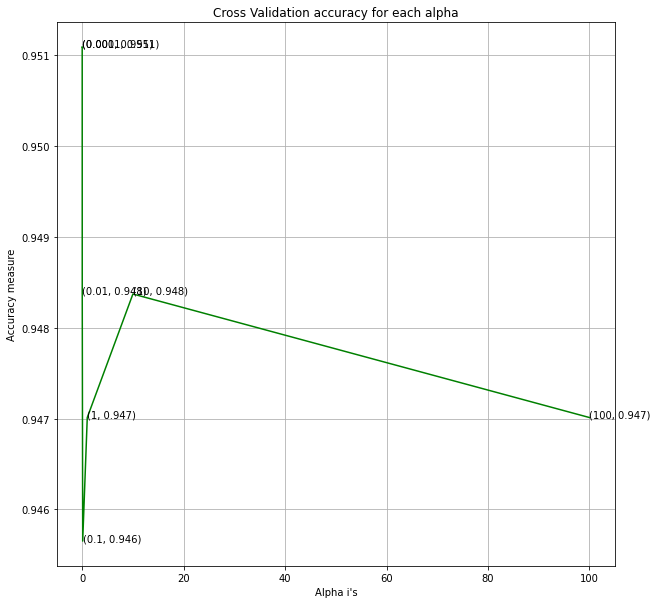

In [ ]:
#Hyperparameter tuning
alpha = [10 ** x for x in range(-4, 3)]
cv_log_error_array=[] 
cv_acc_array = []
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight= 'balanced')
    logisticR.fit(x_train,y_train)
    cv_acc_array.append(accuracy_score(y_cv,logisticR.predict(x_cv)))
    
for i in range(len(cv_acc_array)):
    print('Accuracy for alpha '+str(alpha[i])+' is ',cv_acc_array[i])

best_alpha = np.argmax(cv_acc_array)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, cv_acc_array,c='g')
for i, txt in enumerate(np.round(cv_acc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_acc_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()

Accuracy on test data for final baseline model 0.9326086956521739
Precision on test data for final baseline model 0.9383259911894273
Recall on test data for final baseline model 0.9260869565217391
-------------------------------------------------- Confusion matrix --------------------------------------------------


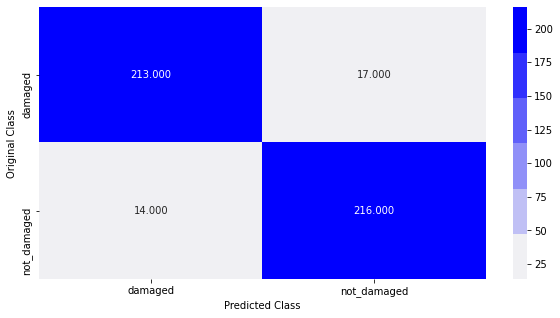

In [ ]:
#Final model using best paramaters from hyperparameter tuning.
base_final=LogisticRegression(penalty='l2',C=alpha[best_alpha])
base_final.fit(x_train,y_train)

#saving the model
save_path = 'vgg16/vgg16_stage1_baseline.sav'
pickle.dump(base_final,open(save_path,'wb'))

#Predcitions and visualization of Confusion matrix
predict_y = base_final.predict(x_test)
print ('Accuracy on test data for final baseline model',accuracy_score(y_test, predict_y))
precision,recall = compute_precision_recall(y_test,predict_y)
print ('Precision on test data for final baseline model',precision)
print ('Recall on test data for final baseline model',recall)
binary_confusion_matrix(y_test,predict_y,stage1_class_labels)

In [ ]:
vgg16_scores = vgg16_scores.append({'Model':'Vgg16_stage1_baseline','Accuracy':'0.933','Precision':'0.938','Recall':'0.926'},ignore_index= True)

### Stage 2

In [ ]:
train_data_dir = 'data_augmentation_1/data_2/train'
test_data_dir = 'data_augmentation_1/data_2/test'

In [ ]:
train_feat,test_feat,train_fd,test_fd = model_features(model_vgg16,train_data_dir, test_data_dir)

Found 1970 images belonging to 3 classes.
Found 179 images belonging to 3 classes.


In [ ]:
train_df = pd.DataFrame(train_feat)
x_test = pd.DataFrame(test_feat)

In [ ]:
train_class = target_feat(train_fd)
y_test = target_feat(test_fd)

In [ ]:
#Dividing the datasets into train and CV for hyperparameter tuning.
x_train,x_cv,y_train,y_cv = train_test_split(train_df,train_class,stratify=train_class,test_size=0.20)

  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
 14%|█▍        | 1/7 [00:23<02:22, 23.69s/it]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:


Accuracy for alpha 0.0001 is  0.8223350253807107
Accuracy for alpha 0.001 is  0.8248730964467005
Accuracy for alpha 0.01 is  0.8248730964467005
Accuracy for alpha 0.1 is  0.8121827411167513
Accuracy for alpha 1 is  0.8147208121827412
Accuracy for alpha 10 is  0.8121827411167513
Accuracy for alpha 100 is  0.8147208121827412


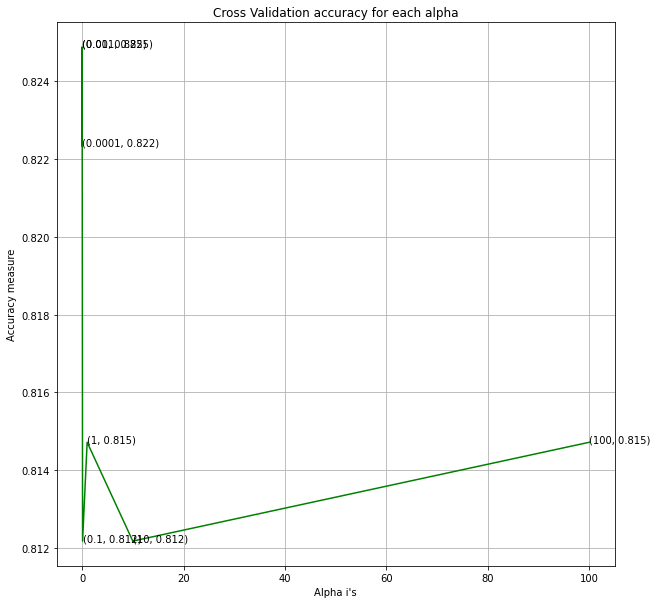

In [ ]:
#Hyperparameter tuning
alpha = [10 ** x for x in range(-4, 3)]
cv_log_error_array=[] 
cv_acc_array = []
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight= 'balanced')
    logisticR.fit(x_train,y_train)
    cv_acc_array.append(accuracy_score(y_cv,logisticR.predict(x_cv)))
    
for i in range(len(cv_acc_array)):
    print('Accuracy for alpha '+str(alpha[i])+' is ',cv_acc_array[i])

best_alpha = np.argmax(cv_acc_array)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, cv_acc_array,c='g')
for i, txt in enumerate(np.round(cv_acc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_acc_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy on test data for final baseline model 0.7374301675977654
Average Precision is 0.7457967015054514
Average Recall is 0.7296554348396578
-------------------------------------------------- Confusion Matrix --------------------------------------------------


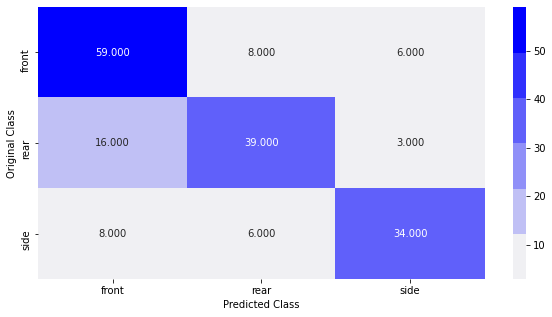

-------------------------------------------------- Precision Matrix --------------------------------------------------


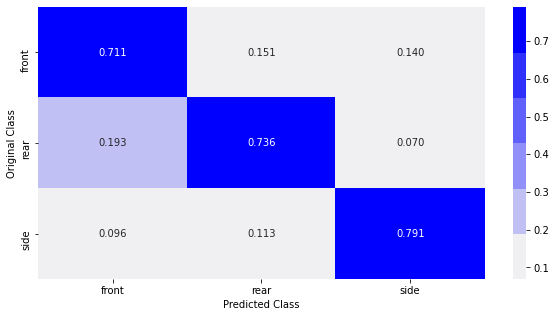

-------------------------------------------------- Recall Matrix --------------------------------------------------


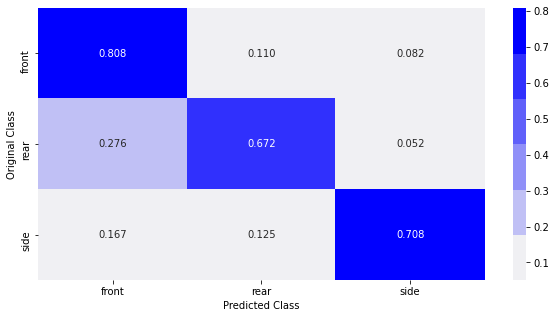

In [ ]:
#Final model using best paramaters from hyperparameter tuning.
base_final=LogisticRegression(penalty='l2',C=alpha[best_alpha])
base_final.fit(x_train,y_train)

#saving the model 
save_path = 'vgg16/vgg16_stage2_baseline.sav'
pickle.dump(base_final,open(save_path,'wb'))

#Predcitions and visualization of Confusion matrix
predict_y = base_final.predict(x_test)
print ('Accuracy on test data for final baseline model',accuracy_score(y_test, predict_y))
multiclass_confusion_matrix(y_test,predict_y,stage2_class_labels)

In [ ]:
vgg16_scores = vgg16_scores.append({'Model':'Vgg16_stage2_baseline','Accuracy':'0.737','Precision':'0.746','Recall':'0.730'},ignore_index= True)

### Stage 3

In [ ]:
train_data_dir = 'data_augmentation_1/data_3/train'
test_data_dir = 'data_augmentation_1/data_3/test'

In [ ]:
train_feat,test_feat,train_fd,test_fd = model_features(model_vgg16,train_data_dir, test_data_dir)

Found 1958 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [ ]:
train_df = pd.DataFrame(train_feat)
x_test = pd.DataFrame(test_feat)

In [ ]:
train_class = target_feat(train_fd)
y_test = target_feat(test_fd)

In [ ]:
#Dividing the datasets into train and CV for hyperparameter tuning.
x_train,x_cv,y_train,y_cv = train_test_split(train_df,train_class,stratify=train_class,test_size=0.20)

  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
 14%|█▍        | 1/7 [00:24<02:24, 24.02s/it]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:


Accuracy for alpha 0.0001 is  0.8188775510204082
Accuracy for alpha 0.001 is  0.8188775510204082
Accuracy for alpha 0.01 is  0.8188775510204082
Accuracy for alpha 0.1 is  0.8214285714285714
Accuracy for alpha 1 is  0.8214285714285714
Accuracy for alpha 10 is  0.8214285714285714
Accuracy for alpha 100 is  0.8163265306122449


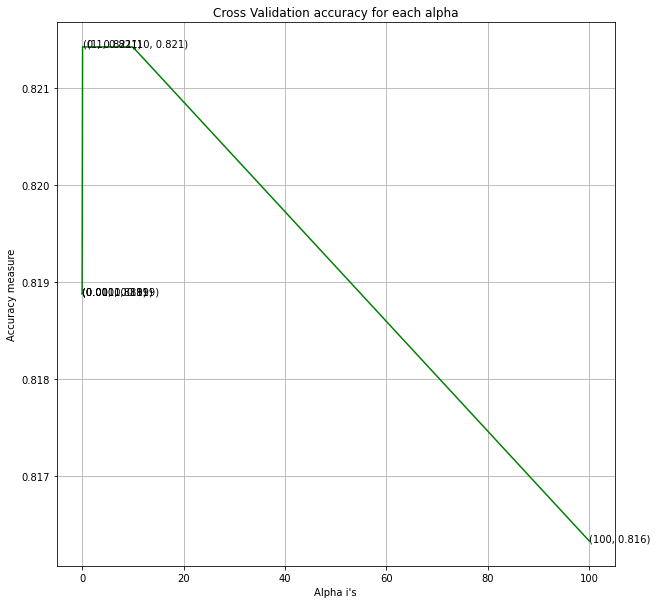

In [ ]:
66#Hyperparameter tuning
alpha = [10 ** x for x in range(-4, 3)]
cv_log_error_array=[] 
cv_acc_array = []
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight= 'balanced')
    logisticR.fit(x_train,y_train)
    cv_acc_array.append(accuracy_score(y_cv,logisticR.predict(x_cv)))
    
for i in range(len(cv_acc_array)):
    print('Accuracy for alpha '+str(alpha[i])+' is ',cv_acc_array[i])

best_alpha = np.argmax(cv_acc_array)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, cv_acc_array,c='g')
for i, txt in enumerate(np.round(cv_acc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_acc_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy on test data for final baseline model 0.6608187134502924
Average Precision is 0.649724111866969
Average Recall is 0.6517231134878193
-------------------------------------------------- Confusion Matrix --------------------------------------------------


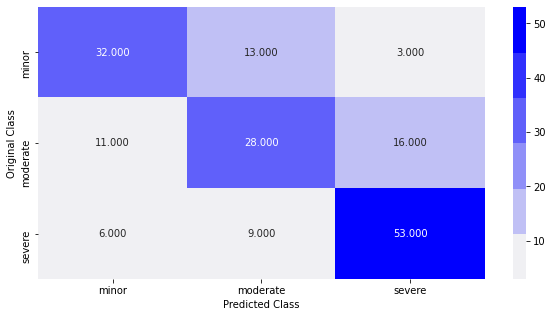

-------------------------------------------------- Precision Matrix --------------------------------------------------


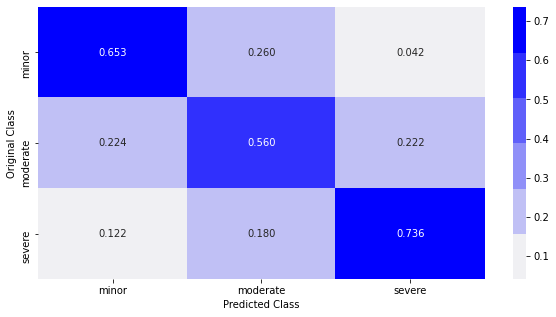

-------------------------------------------------- Recall Matrix --------------------------------------------------


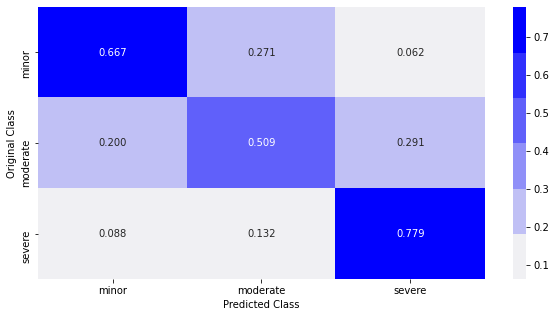

In [38]:
#Final model using best paramaters from hyperparameter tuning.
base_final=LogisticRegression(penalty='l2',C=alpha[best_alpha])
base_final.fit(x_train,y_train)

#saving the model
save_path = 'vgg16/vgg16_stage3_baseline.sav'
pickle.dump(base_final,open(save_path,'wb'))

#Predcitions and visualization of Confusion matrix
predict_y = base_final.predict(x_test)
print ('Accuracy on test data for final baseline model',accuracy_score(y_test, predict_y))
multiclass_confusion_matrix(y_test,predict_y,stage3_class_labels)

In [39]:
vgg16_scores = vgg16_scores.append({'Model':'Vgg16_stage3_baseline','Accuracy':'0.661','Precision':'0.650','Recall':'0.652'},ignore_index= True)

### CNN (Training FC layers only)

In [40]:
def create_model(n_classes,output_activation):
    os.environ['PYTHONHASHSEED'] = '0'
    tf.keras.backend.clear_session()

    ## Set the random seed values to regenerate the model.
    np.random.seed(0)
    rn.seed(0)

    #Input layer
    input_layer = Input(shape=(256,256,3),name='Input_Layer')

    #Adding pretrained model
    vgg16 = applications.VGG16(include_top = False,weights = 'imagenet',input_tensor = input_layer)
    vgg16 = non_trainable(vgg16)

    #Flatten
    flatten = Flatten(data_format='channels_last',name='Flatten')(vgg16.output)

    #FC layer
    FC1 = Dense(units=512,activation='relu',name='FC1')(flatten)

    #FC layer
    FC2 = Dense(units=256,activation='relu',name='FC2')(FC1)

    #Dropout layer
    droput1 = Dropout(0.5)(FC2)

    #output layer
    Out = Dense(units=n_classes,activation=output_activation,name='Output')(droput1)

    #Creating the Model
    model = Model(inputs=input_layer,outputs=Out)

    return model

### Stage 1

In [41]:
model = create_model(1,'sigmoid')

In [42]:
#Compiling the model
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [43]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

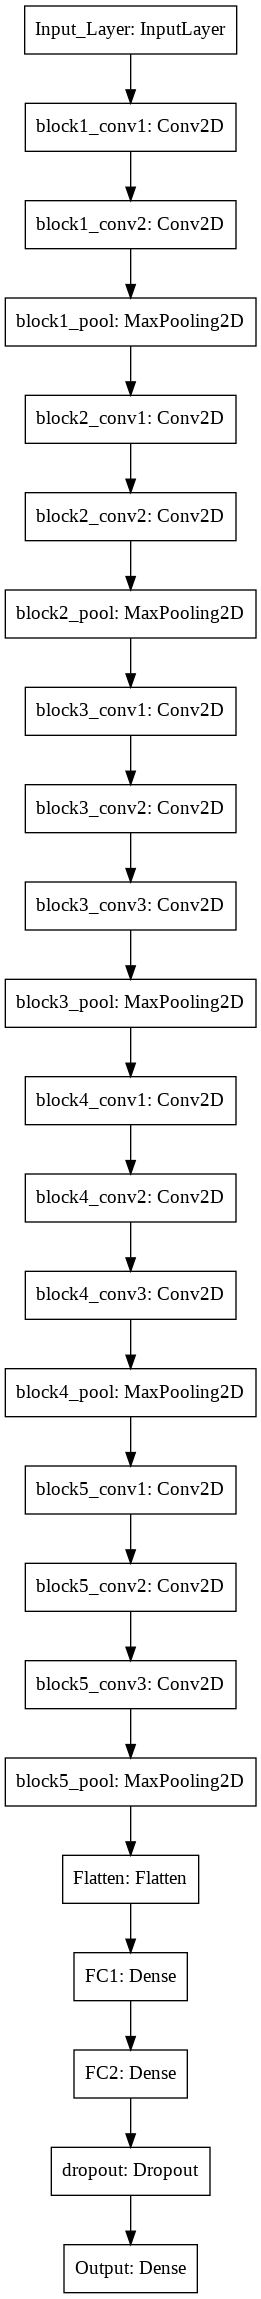

In [44]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [45]:
#Model saving based on validation accuracy score
filepath="vgg16/vgg16_stage1_fc-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [46]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [47]:
train_data_dir = 'data_augmentation_1/data_1/train'
test_data_dir = 'data_augmentation_1/data_1/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")

n_validation_steps = 460/batch_size
n_steps_epoch = 3680/batch_size

Found 3680 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [48]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=50,callbacks=[checkpoint])

Epoch 1/50
460/460 [==============================] - ETA: 0s - loss: 1.8153 - accuracy: 0.8272
Epoch 00001: val_accuracy improved from -inf to 0.89565, saving model to vgg16/vgg16_stage1_fc-0.896.hdf5
460/460 [==============================] - 32s 69ms/step - loss: 1.8153 - accuracy: 0.8272 - val_loss: 0.7112 - val_accuracy: 0.8957
Epoch 2/50
460/460 [==============================] - ETA: 0s - loss: 0.3796 - accuracy: 0.9264
Epoch 00002: val_accuracy improved from 0.89565 to 0.90435, saving model to vgg16/vgg16_stage1_fc-0.904.hdf5
460/460 [==============================] - 32s 69ms/step - loss: 0.3796 - accuracy: 0.9264 - val_loss: 0.6688 - val_accuracy: 0.9043
Epoch 3/50
460/460 [==============================] - ETA: 0s - loss: 0.2248 - accuracy: 0.9476
Epoch 00003: val_accuracy improved from 0.90435 to 0.90870, saving model to vgg16/vgg16_stage1_fc-0.909.hdf5
460/460 [==============================] - 32s 70ms/step - loss: 0.2248 - accuracy: 0.9476 - val_loss: 0.5797 - val_accura

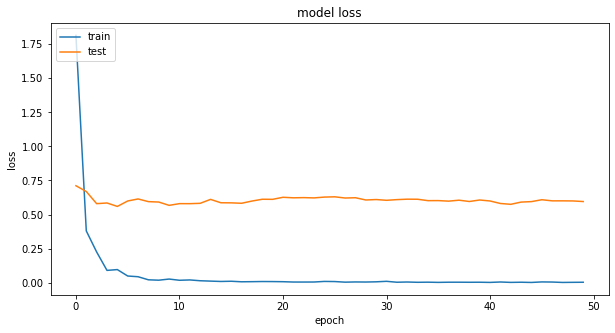

The loss for final model is  0.5981032848358154


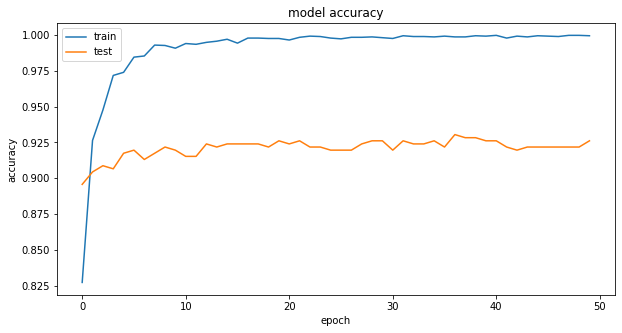

The accuracy for final model is  0.9304347634315491


In [49]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [50]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1, class_mode = "binary",shuffle = False)

Found 460 images belonging to 2 classes.


In [51]:
best_model = load_model('vgg16/vgg16_stage1_fc-0.930.hdf5')

In [52]:
y_pred = best_model.predict(x_test)

In [53]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  if i <= .5:
    y_predicted.append('damaged')
  elif i > .5:
    y_predicted.append('not_damaged')

Precision on test data for final baseline model 0.9194915254237288
Recall on test data for final baseline model 0.9434782608695652
-------------------------------------------------- Confusion matrix --------------------------------------------------


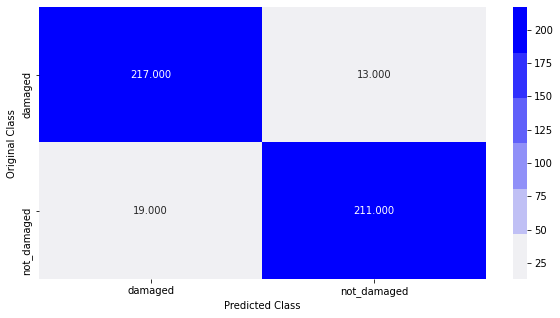

In [54]:
precision,recall = compute_precision_recall(y_true,y_predicted)
print ('Precision on test data for final baseline model',precision)
print ('Recall on test data for final baseline model',recall)
binary_confusion_matrix(y_true,y_predicted,stage1_class_labels)

In [55]:
vgg16_scores = vgg16_scores.append({'Model':'Vgg16_stage1 FC','Accuracy':'0.930','Precision':'0.919','Recall':'0.943'},ignore_index= True)

### Stage 2

In [56]:
model = create_model(3,'softmax')

In [57]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [58]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

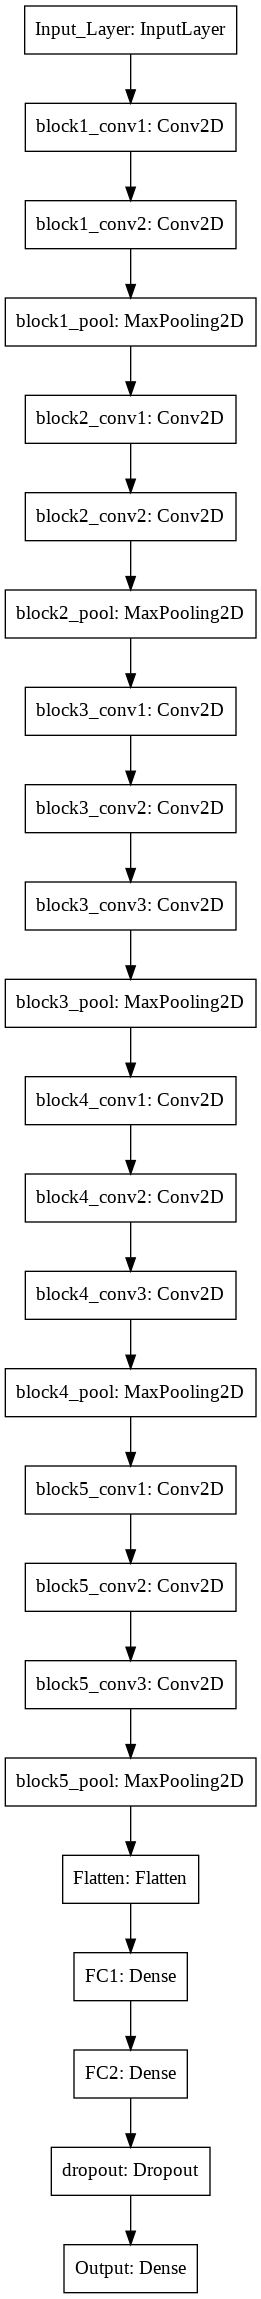

In [59]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [60]:
#Model saving based on validation accuracy score
filepath="vgg16/vgg16_stage2_fc-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [61]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [62]:
train_data_dir = 'data_augmentation_1/data_2/train'
test_data_dir = 'data_augmentation_1/data_2/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 179/batch_size
n_steps_epoch = 1970/batch_size

Found 1970 images belonging to 3 classes.
Found 179 images belonging to 3 classes.


In [63]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=50,callbacks=[checkpoint])

Epoch 1/50
247/246 [==============================] - ETA: 0s - loss: 6.7872 - accuracy: 0.5025
Epoch 00001: val_accuracy improved from -inf to 0.55307, saving model to vgg16/vgg16_stage2_fc-0.553.hdf5
247/246 [==============================] - 16s 66ms/step - loss: 6.7872 - accuracy: 0.5025 - val_loss: 2.9728 - val_accuracy: 0.5531
Epoch 2/50
247/246 [==============================] - ETA: 0s - loss: 1.4506 - accuracy: 0.7594
Epoch 00002: val_accuracy improved from 0.55307 to 0.63128, saving model to vgg16/vgg16_stage2_fc-0.631.hdf5
247/246 [==============================] - 16s 64ms/step - loss: 1.4506 - accuracy: 0.7594 - val_loss: 1.9265 - val_accuracy: 0.6313
Epoch 3/50
247/246 [==============================] - ETA: 0s - loss: 0.5997 - accuracy: 0.8492
Epoch 00003: val_accuracy did not improve from 0.63128
247/246 [==============================] - 16s 63ms/step - loss: 0.5997 - accuracy: 0.8492 - val_loss: 1.9793 - val_accuracy: 0.6257
Epoch 4/50
247/246 [=======================

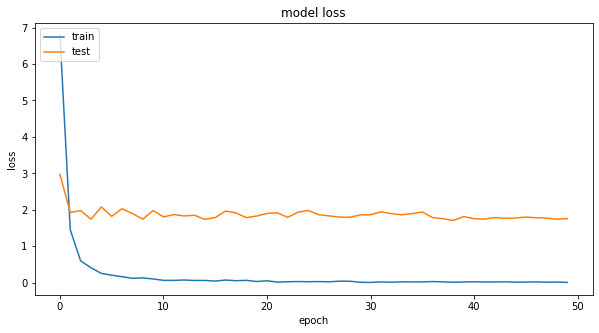

The loss for final model is  1.7818559408187866


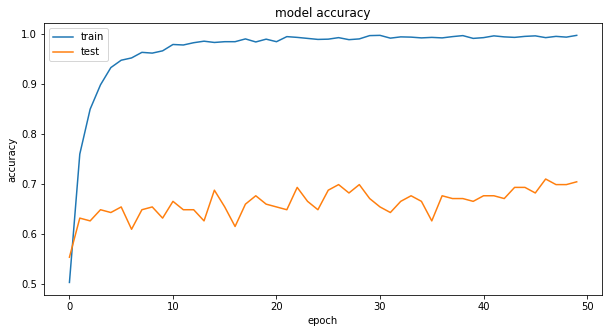

The accuracy for final model is  0.7094972133636475


In [64]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [65]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 179 images belonging to 3 classes.


In [67]:
best_model = load_model('vgg16/vgg16_stage2_fc-0.709.hdf5')

In [68]:
y_pred = best_model.predict(x_test)

In [69]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  n = np.argmax(i)
  if n == 0:
    y_predicted.append('front')
  elif n== 1:
    y_predicted.append('rear')
  elif n == 2:
    y_predicted.append('side')

Average Precision is 0.7168209876543209
Average Recall is 0.7068407862278906
-------------------------------------------------- Confusion Matrix --------------------------------------------------


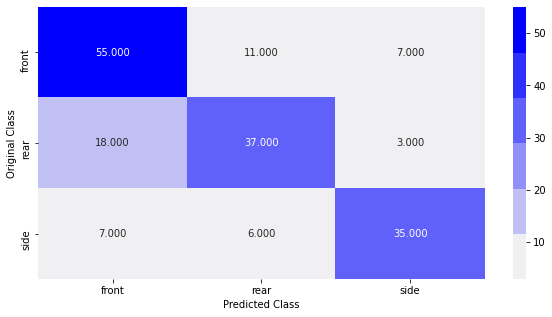

-------------------------------------------------- Precision Matrix --------------------------------------------------


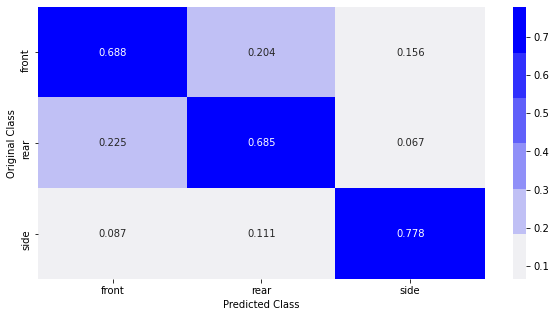

-------------------------------------------------- Recall Matrix --------------------------------------------------


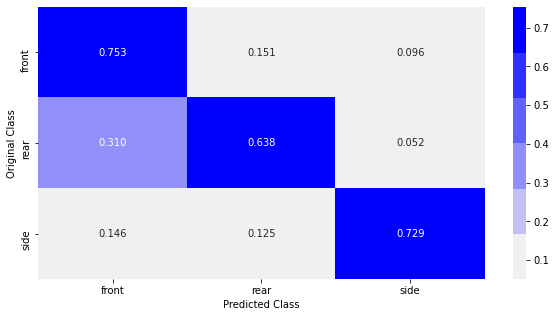

In [70]:
multiclass_confusion_matrix(y_true,y_predicted,stage2_class_labels)

In [71]:
vgg16_scores = vgg16_scores.append({'Model':'Vgg16_stage2 FC','Accuracy':'0.709','Precision':'0.717','Recall':'0.707'},ignore_index= True)

### Stage 3

In [72]:
model = create_model(3,'softmax')

In [73]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [75]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

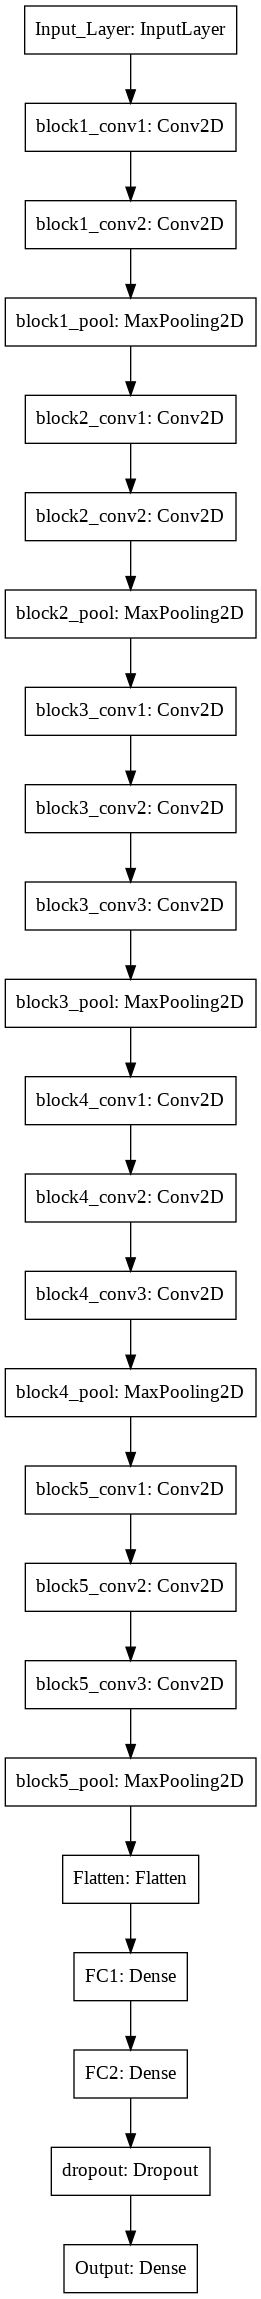

In [77]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [78]:
#Model saving based on validation accuracy score
filepath="vgg16/vgg16_stage3_fc-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [79]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [81]:
train_data_dir = 'data_augmentation_1/data_3/train'
test_data_dir = 'data_augmentation_1/data_3/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 171/batch_size
n_steps_epoch = 1958/batch_size

Found 1958 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [82]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=50,callbacks=[checkpoint])

Epoch 1/50
245/244 [==============================] - ETA: 0s - loss: 5.7159 - accuracy: 0.5174
Epoch 00001: val_accuracy improved from -inf to 0.58480, saving model to vgg16/vgg16_stage3_fc-0.585.hdf5
245/244 [==============================] - 16s 66ms/step - loss: 5.7159 - accuracy: 0.5174 - val_loss: 2.5951 - val_accuracy: 0.5848
Epoch 2/50
245/244 [==============================] - ETA: 0s - loss: 1.2080 - accuracy: 0.7686
Epoch 00002: val_accuracy improved from 0.58480 to 0.61404, saving model to vgg16/vgg16_stage3_fc-0.614.hdf5
245/244 [==============================] - 16s 64ms/step - loss: 1.2080 - accuracy: 0.7686 - val_loss: 2.5623 - val_accuracy: 0.6140
Epoch 3/50
245/244 [==============================] - ETA: 0s - loss: 0.5911 - accuracy: 0.8463
Epoch 00003: val_accuracy improved from 0.61404 to 0.61988, saving model to vgg16/vgg16_stage3_fc-0.620.hdf5
245/244 [==============================] - 16s 64ms/step - loss: 0.5911 - accuracy: 0.8463 - val_loss: 2.1390 - val_accura

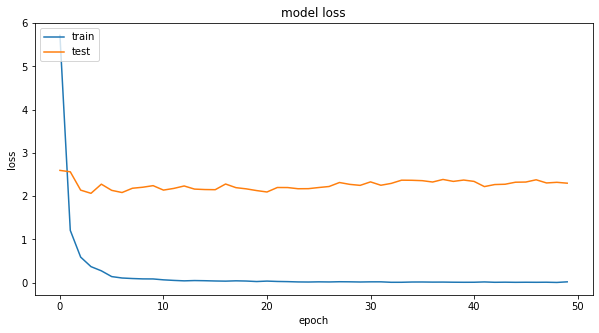

The loss for final model is  2.0651118755340576


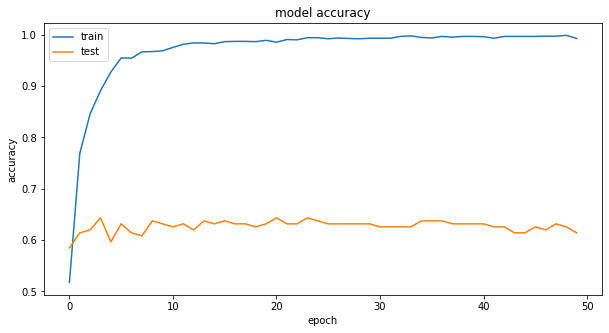

The accuracy for final model is  0.6432748436927795


In [83]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [84]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 171 images belonging to 3 classes.


In [88]:
best_model = load_model('vgg16/vgg16_stage3_fc-0.643.hdf5')

In [89]:
y_pred = best_model.predict(x_test)

In [90]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  n = np.argmax(i)
  if n == 0:
    y_predicted.append('minor')
  elif n== 1:
    y_predicted.append('moderate')
  elif n == 2:
    y_predicted.append('severe')

Average Precision is 0.6502555824589723
Average Recall is 0.6370172311348782
-------------------------------------------------- Confusion Matrix --------------------------------------------------


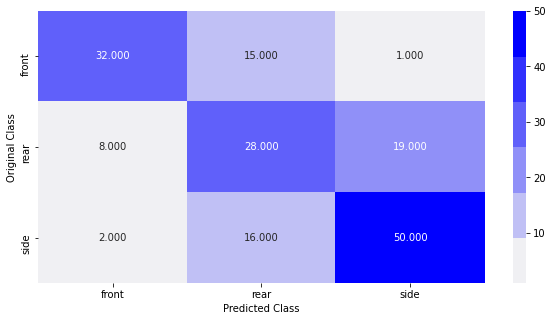

-------------------------------------------------- Precision Matrix --------------------------------------------------


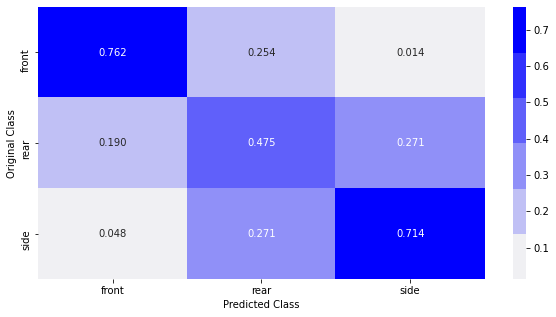

-------------------------------------------------- Recall Matrix --------------------------------------------------


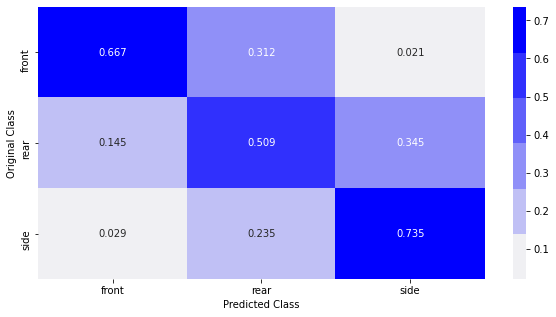

In [91]:
multiclass_confusion_matrix(y_true,y_predicted,stage2_class_labels)

In [92]:
vgg16_scores = vgg16_scores.append({'Model':'Vgg16_stage3 FC','Accuracy':'0.643','Precision':'0.650','Recall':'0.637'},ignore_index= True)

### CNN (Training All layers only)

In [93]:
def create_model(n_classes,output_activation):
    os.environ['PYTHONHASHSEED'] = '0'
    tf.keras.backend.clear_session()

    ## Set the random seed values to regenerate the model.
    np.random.seed(0)
    rn.seed(0)

    #Input layer
    input_layer = Input(shape=(256,256,3),name='Input_Layer')

    #Adding pretrained model
    vgg16 = applications.VGG16(include_top = False,weights = 'imagenet',input_tensor = input_layer)

    #Flatten
    flatten = Flatten(data_format='channels_last',name='Flatten')(vgg16.output)

    #FC layer
    FC1 = Dense(units=512,activation='relu',name='FC1')(flatten)

    #FC layer
    FC2 = Dense(units=256,activation='relu',name='FC2')(FC1)

    #Dropout layer
    droput1 = Dropout(0.5)(FC2)

    #output layer
    Out = Dense(units=n_classes,activation=output_activation,name='Output')(droput1)

    #Creating the Model
    model = Model(inputs=input_layer,outputs=Out)

    return model

### Stage 1

In [94]:
model = create_model(1,'sigmoid')

In [95]:
#Compiling the model
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [96]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

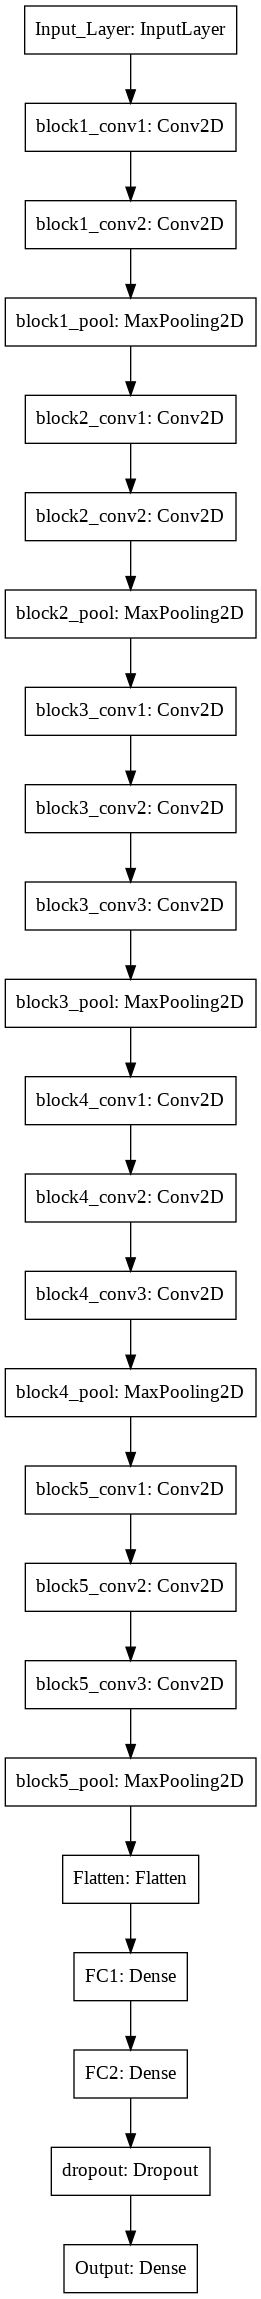

In [97]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [98]:
#Model saving based on validation accuracy score
filepath="vgg16/vgg16_stage1_all-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [99]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [100]:
train_data_dir = 'data_augmentation_1/data_1/train'
test_data_dir = 'data_augmentation_1/data_1/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")

n_validation_steps = 460/batch_size
n_steps_epoch = 3680/batch_size

Found 3680 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [101]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=50,callbacks=[checkpoint])

Epoch 1/50
460/460 [==============================] - ETA: 0s - loss: 0.7265 - accuracy: 0.7918
Epoch 00001: val_accuracy improved from -inf to 0.90000, saving model to vgg16/vgg16_stage1_all-0.900.hdf5
460/460 [==============================] - 81s 175ms/step - loss: 0.7265 - accuracy: 0.7918 - val_loss: 0.2494 - val_accuracy: 0.9000
Epoch 2/50
460/460 [==============================] - ETA: 0s - loss: 0.2766 - accuracy: 0.8889
Epoch 00002: val_accuracy improved from 0.90000 to 0.91739, saving model to vgg16/vgg16_stage1_all-0.917.hdf5
460/460 [==============================] - 87s 188ms/step - loss: 0.2766 - accuracy: 0.8889 - val_loss: 0.2017 - val_accuracy: 0.9174
Epoch 3/50
460/460 [==============================] - ETA: 0s - loss: 0.1784 - accuracy: 0.9274
Epoch 00003: val_accuracy improved from 0.91739 to 0.92174, saving model to vgg16/vgg16_stage1_all-0.922.hdf5
460/460 [==============================] - 86s 188ms/step - loss: 0.1784 - accuracy: 0.9274 - val_loss: 0.1956 - val_

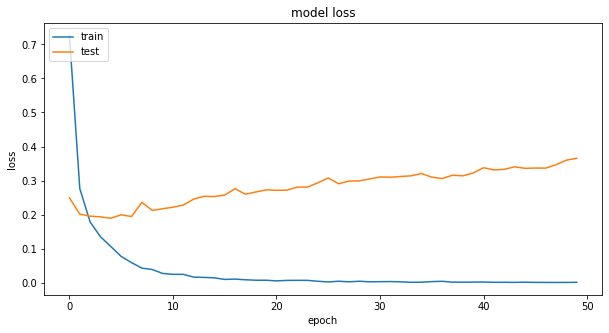

The loss for final model is  0.2809939980506897


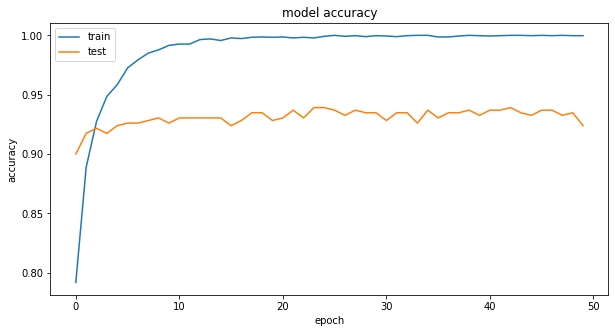

The accuracy for final model is  0.939130425453186


In [102]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [103]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1, class_mode = "binary",shuffle = False)

Found 460 images belonging to 2 classes.


In [104]:
best_model = load_model('vgg16/vgg16_stage1_all-0.939.hdf5')

In [105]:
y_pred = best_model.predict(x_test)

In [106]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  if i <= .5:
    y_predicted.append('damaged')
  elif i > .5:
    y_predicted.append('not_damaged')

Precision on test data for final baseline model 0.9353448275862069
Recall on test data for final baseline model 0.9434782608695652
-------------------------------------------------- Confusion matrix --------------------------------------------------


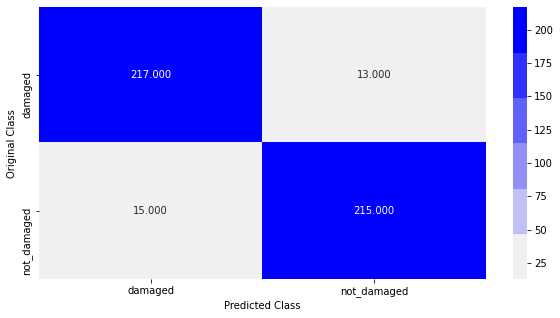

In [107]:
precision,recall = compute_precision_recall(y_true,y_predicted)
print ('Precision on test data for final baseline model',precision)
print ('Recall on test data for final baseline model',recall)
binary_confusion_matrix(y_true,y_predicted,stage1_class_labels)

In [108]:
vgg16_scores = vgg16_scores.append({'Model':'Vgg16_stage1 all','Accuracy':'0.939','Precision':'0.935','Recall':'0.943'},ignore_index= True)

### Stage 2

In [109]:
model = create_model(3,'softmax')

In [110]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [111]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

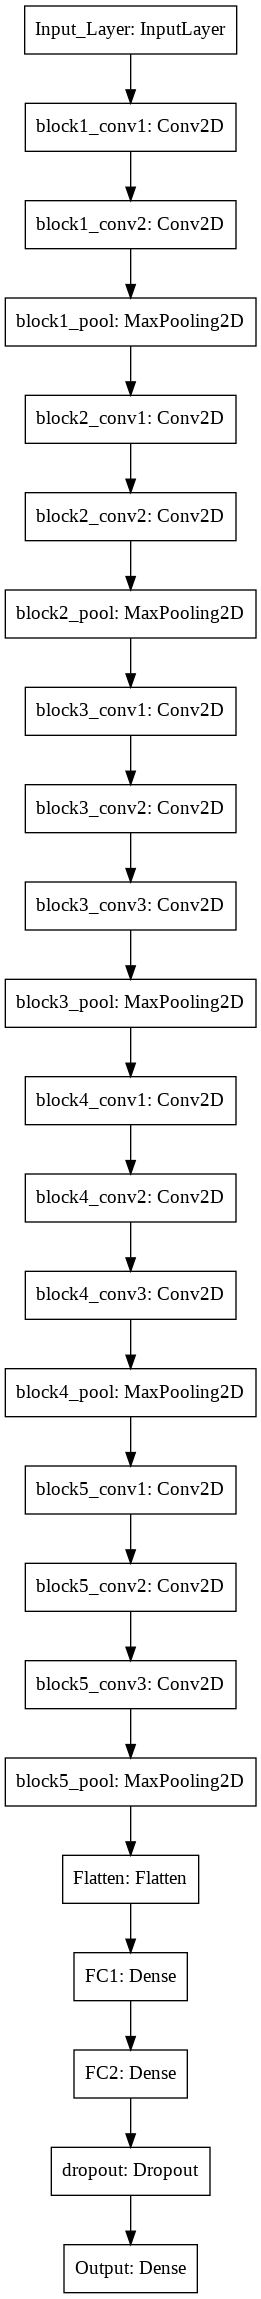

In [112]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [113]:
#Model saving based on validation accuracy score
filepath="vgg16/vgg16_stage2_all-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [114]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [115]:
train_data_dir = 'data_augmentation_1/data_2/train'
test_data_dir = 'data_augmentation_1/data_2/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 179/batch_size
n_steps_epoch = 1970/batch_size

Found 1970 images belonging to 3 classes.
Found 179 images belonging to 3 classes.


In [116]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=50,callbacks=[checkpoint])

Epoch 1/50
247/246 [==============================] - ETA: 0s - loss: 1.8929 - accuracy: 0.3827
Epoch 00001: val_accuracy improved from -inf to 0.40782, saving model to vgg16/vgg16_stage2_all-0.408.hdf5
247/246 [==============================] - 45s 184ms/step - loss: 1.8929 - accuracy: 0.3827 - val_loss: 1.0644 - val_accuracy: 0.4078
Epoch 2/50
247/246 [==============================] - ETA: 0s - loss: 1.0690 - accuracy: 0.4416
Epoch 00002: val_accuracy did not improve from 0.40782
247/246 [==============================] - 46s 186ms/step - loss: 1.0690 - accuracy: 0.4416 - val_loss: 1.0596 - val_accuracy: 0.4078
Epoch 3/50
247/246 [==============================] - ETA: 0s - loss: 1.0509 - accuracy: 0.4558
Epoch 00003: val_accuracy improved from 0.40782 to 0.42458, saving model to vgg16/vgg16_stage2_all-0.425.hdf5
247/246 [==============================] - 46s 186ms/step - loss: 1.0509 - accuracy: 0.4558 - val_loss: 1.0643 - val_accuracy: 0.4246
Epoch 4/50
247/246 [==================

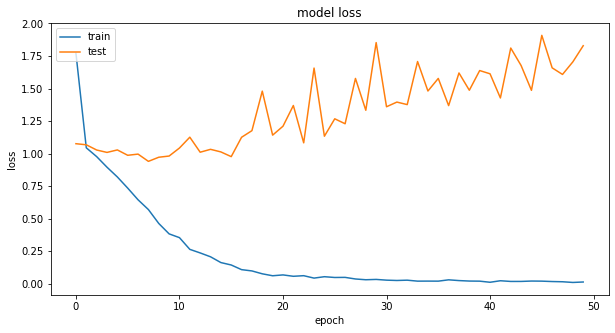

The loss for final model is  1.4272770881652832


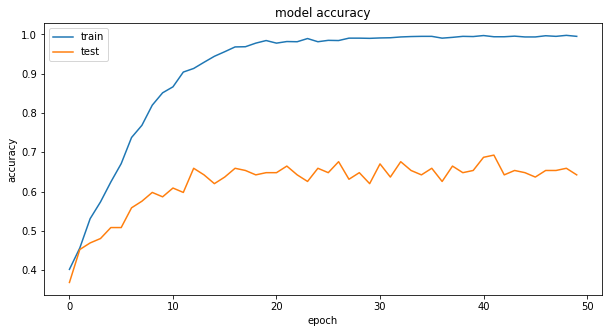

The accuracy for final model is  0.6927374005317688


In [ ]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [ ]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 179 images belonging to 3 classes.


In [ ]:
best_model = load_model('vgg16/vgg16_stage2_all-0.693.hdf5')

In [ ]:
y_pred = best_model.predict(x_test)

In [ ]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  n = np.argmax(i)
  if n == 0:
    y_predicted.append('front')
  elif n== 1:
    y_predicted.append('rear')
  elif n == 2:
    y_predicted.append('side')

Average Precision is 0.7117145235122763
Average Recall is 0.6776918333070907
-------------------------------------------------- Confusion Matrix --------------------------------------------------


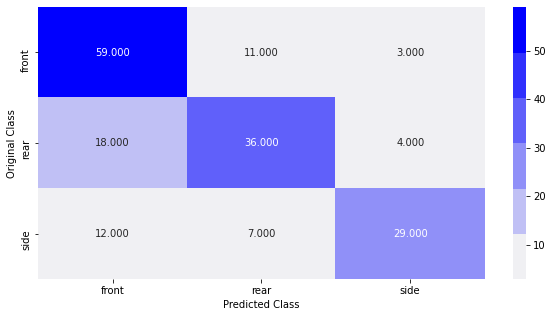

-------------------------------------------------- Precision Matrix --------------------------------------------------


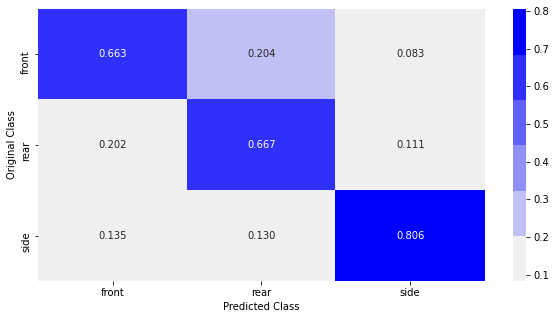

-------------------------------------------------- Recall Matrix --------------------------------------------------


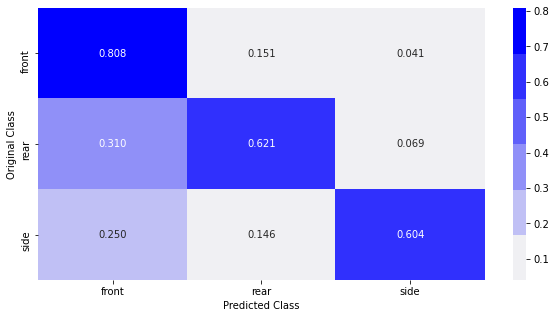

In [ ]:
multiclass_confusion_matrix(y_true,y_predicted,stage2_class_labels)

In [ ]:
vgg16_scores = vgg16_scores.append({'Model':'Vgg16_stage2 all','Accuracy':'0.693','Precision':'0.712','Recall':'0.678'},ignore_index= True)

### Stage 3

In [ ]:
model = create_model(3,'softmax')

In [ ]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

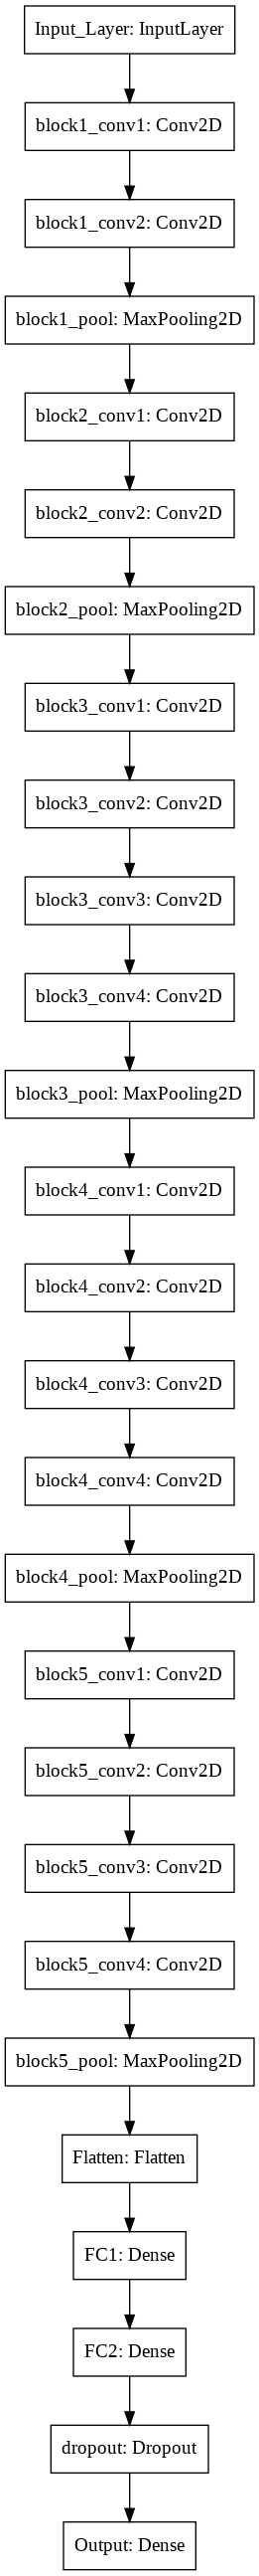

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [ ]:
#Model saving based on validation accuracy score
filepath="vgg16/vgg16_stage3_all-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [ ]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [ ]:
train_data_dir = 'data_augmentation_1/data_3/train'
test_data_dir = 'data_augmentation_1/data_3/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 171/batch_size
n_steps_epoch = 1958/batch_size

Found 1958 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [ ]:
model.fit(train_generator   ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=50,callbacks=[checkpoint])

Epoch 1/50
245/244 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9995
Epoch 00001: val_accuracy improved from -inf to 0.58480, saving model to vgg19/vgg19_stage3_all-0.585.hdf5
245/244 [==============================] - 57s 231ms/step - loss: 0.0059 - accuracy: 0.9995 - val_loss: 2.0782 - val_accuracy: 0.5848
Epoch 2/50
245/244 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.9918
Epoch 00002: val_accuracy did not improve from 0.58480
245/244 [==============================] - 55s 225ms/step - loss: 0.0239 - accuracy: 0.9918 - val_loss: 2.1083 - val_accuracy: 0.5848
Epoch 3/50
245/244 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9964
Epoch 00003: val_accuracy did not improve from 0.58480
245/244 [==============================] - 55s 226ms/step - loss: 0.0107 - accuracy: 0.9964 - val_loss: 2.0100 - val_accuracy: 0.5731
Epoch 4/50
245/244 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.99

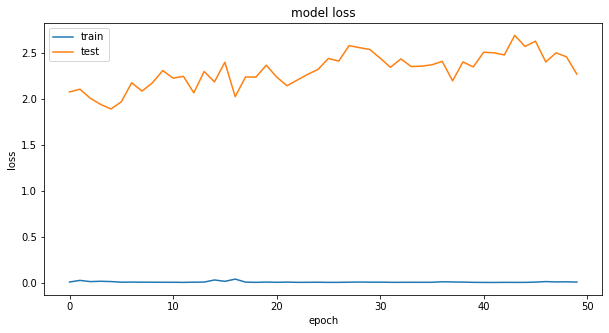

The loss for final model is  2.3112077713012695


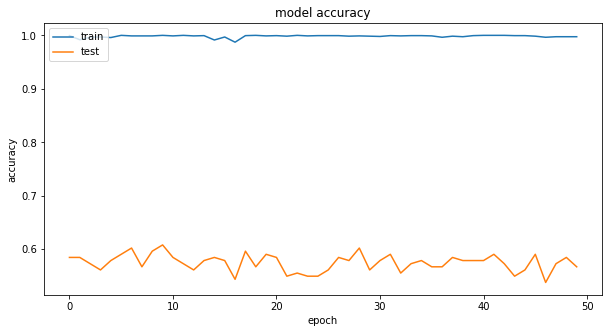

The accuracy for final model is  0.6081871390342712


In [ ]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [ ]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 171 images belonging to 3 classes.


In [ ]:
best_model = load_model('vgg16/vgg16_stage3_all-0.608.hdf5')

In [ ]:
y_pred = best_model.predict(x_test)

In [ ]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  n = np.argmax(i)
  if n == 0:
    y_predicted.append('minor')
  elif n== 1:
    y_predicted.append('moderate')
  elif n == 2:
    y_predicted.append('severe')

Average Precision is 0.6084597360956961
Average Recall is 0.5866310160427807
-------------------------------------------------- Confusion Matrix --------------------------------------------------


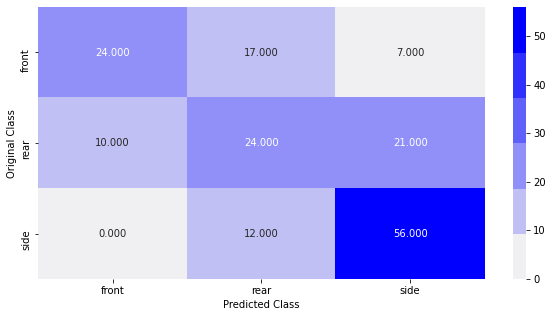

-------------------------------------------------- Precision Matrix --------------------------------------------------


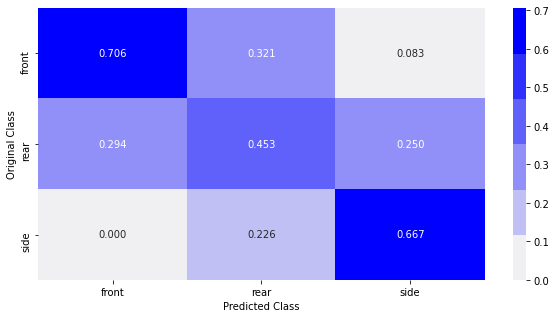

-------------------------------------------------- Recall Matrix --------------------------------------------------


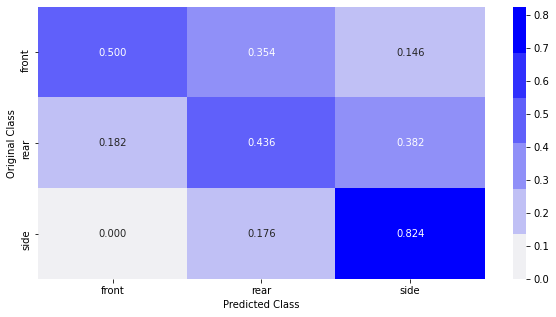

In [ ]:
multiclass_confusion_matrix(y_true,y_predicted,stage2_class_labels)

In [ ]:
vgg16_scores = vgg16_scores.append({'Model':'Vgg16_stage3 all','Accuracy':'0.608','Precision':'0.608','Recall':'0.587'},ignore_index= True)

In [ ]:
vgg16_scores.to_csv('vgg16_scores.csv',index=False)